In [1]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import pickle
import nltk
import os

## Macrogrades

In [2]:
path = 'dataset-grades'
filename = 'qb_grades.csv'

df = pd.read_csv(os.path.join(path, filename))
df.head(3)

,Player,Year,Race,Report_Count,Mental_Count,Mental_Positive,Mental_Negative,Mental_Net,Athleticism_Count,Athleticism_Positive,...,Technique_Negative,Technique_Net,NaturalTalent_Count,NaturalTalent_Positive,NaturalTalent_Negative,NaturalTalent_Net,FootballIntelligence_Count,FootballIntelligence_Positive,FootballIntelligence_Negative,FootballIntelligence_Net
0,Chris Leak,2007,Non-White,10,2,0.5,0.5,0.0,3,1.000000,...,0.0,0.0,4,0.25,0.75,-0.5,1,1.0,0.0,1.0
1,John Beck,2007,White,12,2,1.0,0.0,1.0,2,0.000000,...,0.0,1.0,2,1.00,0.00,1.0,2,1.0,0.0,1.0
2,Drew Stanton,2007,White,13,3,1.0,0.0,1.0,7,0.571429,...,1.0,-1.0,1,1.00,0.00,1.0,1,1.0,0.0,1.0


In [3]:
# Create Overall Score
df['Overall_Net'] = ((df['Mental_Net'] * df['Mental_Count']) + (df['Athleticism_Net'] * df['Athleticism_Count']) + (df['Technique_Net'] * df['Technique_Count']) + (df['NaturalTalent_Net'] * df['NaturalTalent_Count']) + (df['FootballIntelligence_Net'] * df['FootballIntelligence_Count'])) / df['Report_Count']
df['Overall_Positive'] = ((df['Mental_Positive'] * df['Mental_Count']) + (df['Athleticism_Positive'] * df['Athleticism_Count']) + (df['Technique_Positive'] * df['Technique_Count']) + (df['NaturalTalent_Positive'] * df['NaturalTalent_Count']) + (df['FootballIntelligence_Positive'] * df['FootballIntelligence_Count'])) / df['Report_Count']
df['Overall_Negative'] = ((df['Mental_Negative'] * df['Mental_Count']) + (df['Athleticism_Negative'] * df['Athleticism_Count']) + (df['Technique_Negative'] * df['Technique_Count']) + (df['NaturalTalent_Negative'] * df['NaturalTalent_Count']) + (df['FootballIntelligence_Negative'] * df['FootballIntelligence_Count'])) / df['Report_Count']

In [4]:
# Split into Training and Test Data
X_train = df[['Mental_Net', 'Overall_Net', 'Athleticism_Net', 'Technique_Net', 'FootballIntelligence_Net', 'NaturalTalent_Net']]
y_train = np.asarray(df['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(212, 6)
(212,)


In [5]:
model = sm.Logit(y_train, X_train).fit(maxiter=100000)

Optimization terminated successfully.
         Current function value: 0.560067
         Iterations 6


In [6]:
# Define function to output plot of the model coefficients

def coefplot(results, figsize=(15, 10), sign=False, title='Coefficients of Features w/ 95% Confidence Intervals', title_fontsize=45, orientation=0):

    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    
    # Only Significat Features
    if sign:
        coef_df = coef_df[coef_df['P>|z|'].astype(float) < 0.05]

    ### Plot Coefficients ###

    # Labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster' will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', 
                 kind='bar', ax=ax, 
                 color='none', fontsize=22.5, 
                 ecolor='steelblue', capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title(title, fontsize=title_fontsize)
    ax.set_ylabel('Coefficients', fontsize=25)
    ax.set_xlabel('', fontsize=25)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', 
               s=80, 
               y=coef_df['coef'], 
               color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    plt.xticks(rotation=orientation)
    
    return plt.show()

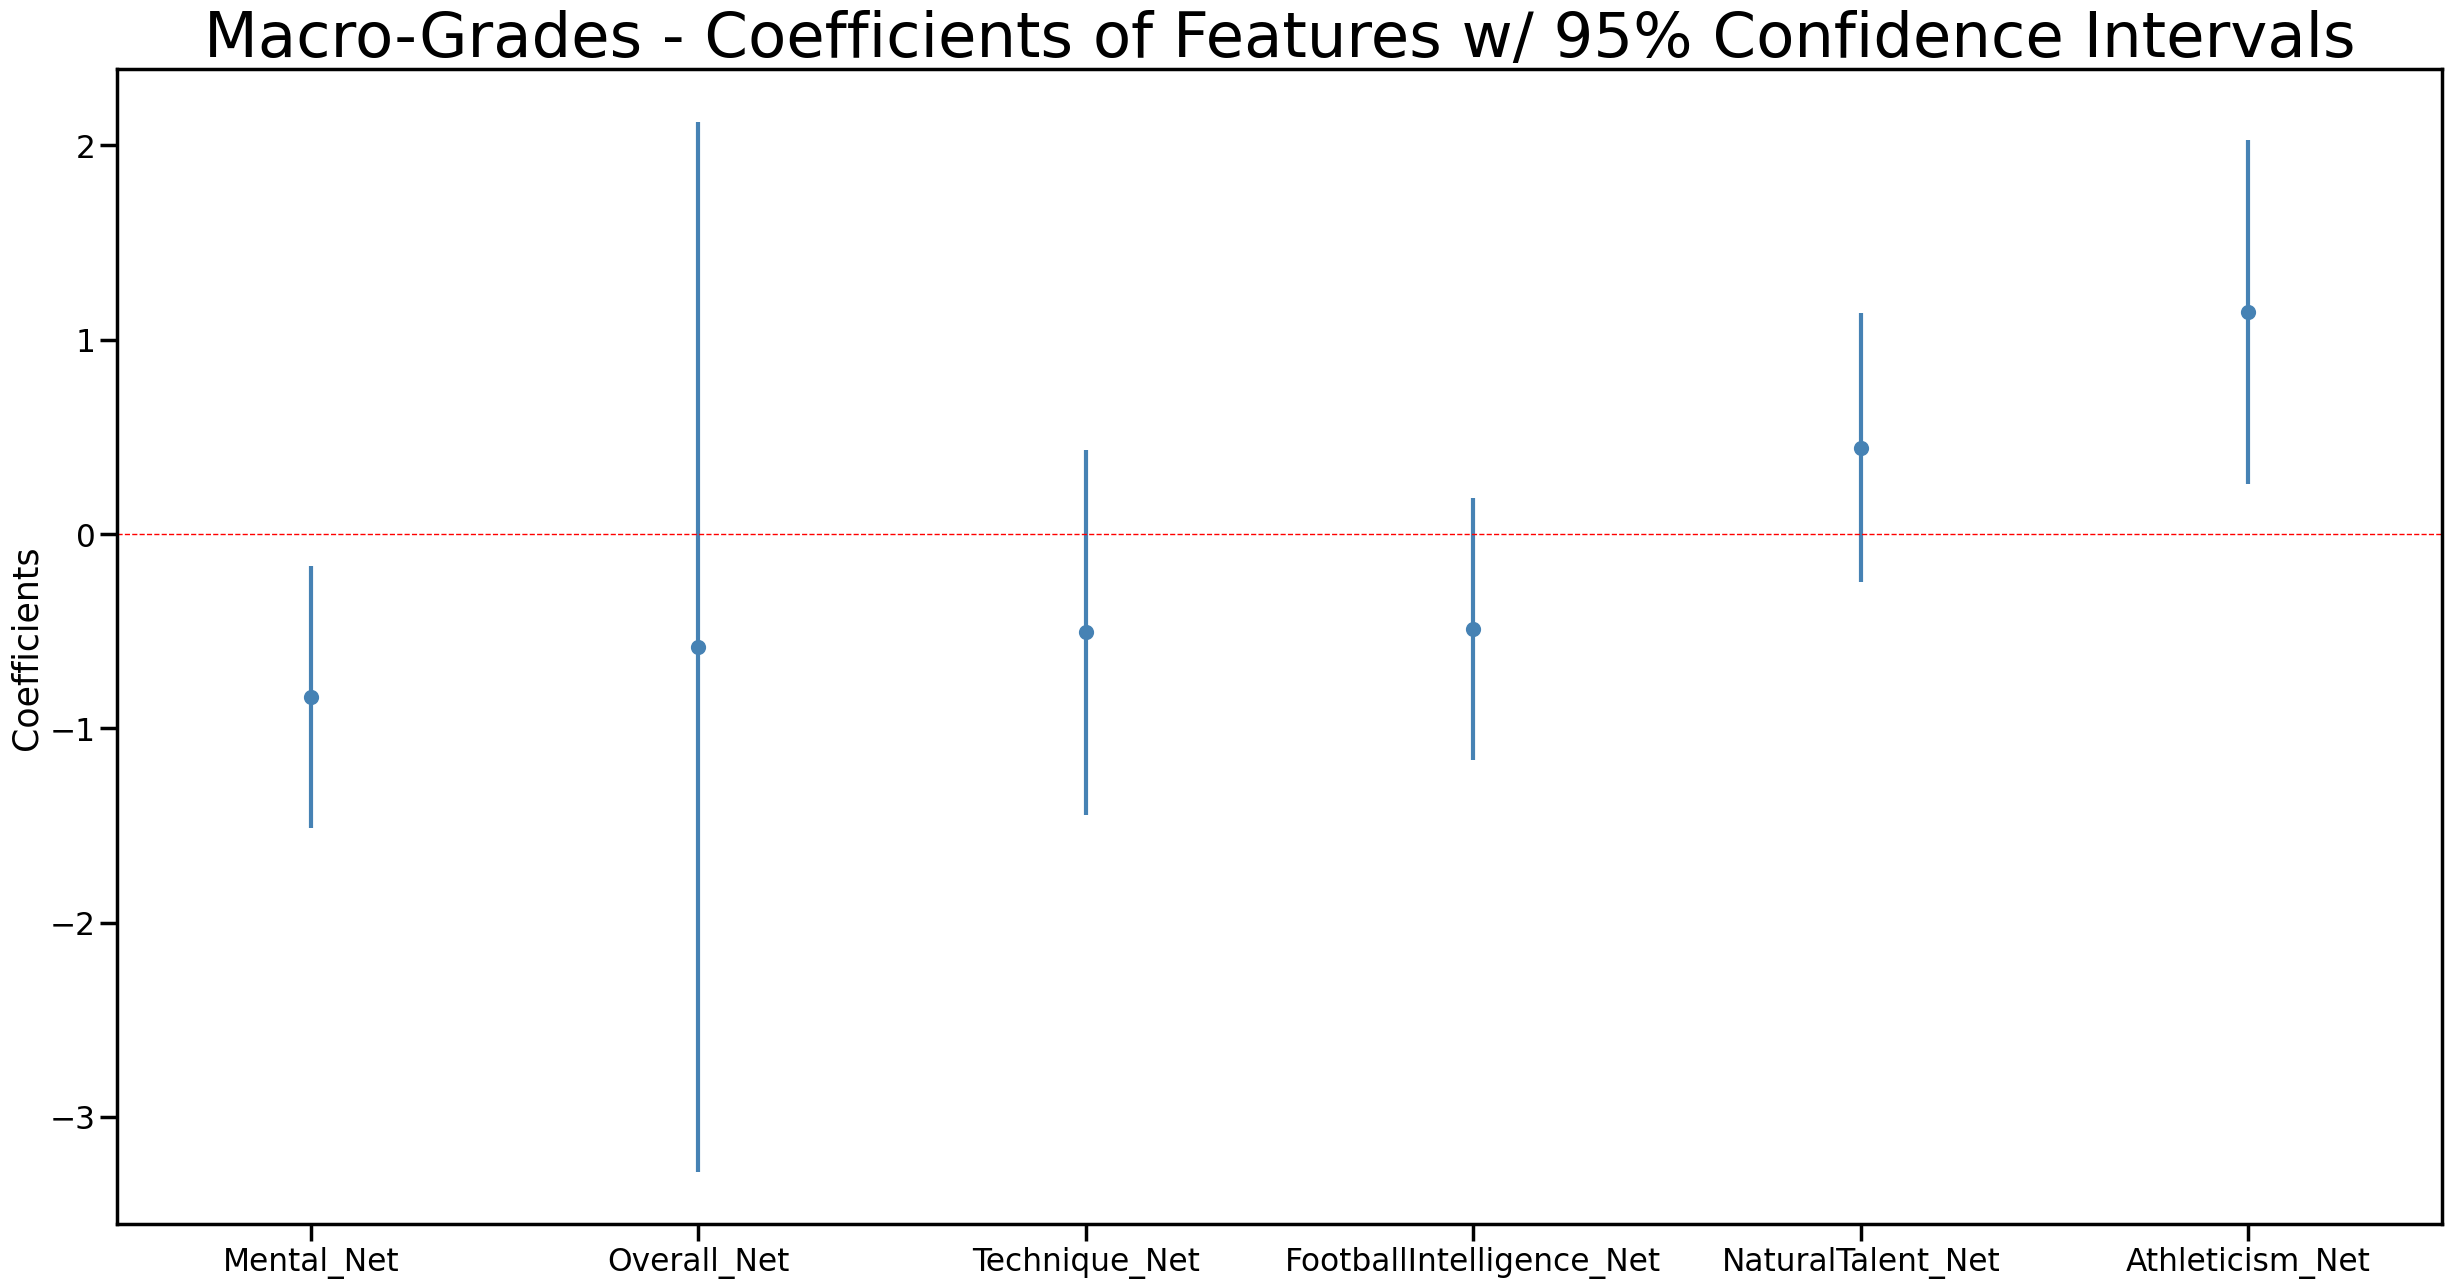

In [7]:
coefplot(model, figsize=(30, 15), sign=False, title='Macro-Grades - Coefficients of Features w/ 95% Confidence Intervals')

In [26]:
# Random Forest
grid = {'criterion' : ['gini', 'entropy'],
        'max_depth': [50, 100, None],
        'max_features': ['sqrt'],
        'n_estimators': [100, 500, 1000]}

classifier = RandomForestClassifier()
classifier_cv = GridSearchCV(classifier, grid, cv=5, scoring='f1_micro')
classifier_cv.fit(X_train, y_train)

print('Tuned Hyperparameters: ',  classifier_cv.best_params_)
print('F1 :', classifier_cv.best_score_)

Tuned Hyperparameters:  {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 100}
F1 : 0.7070874861572535


In [32]:
classifier = RandomForestClassifier(criterion='gini', max_depth=50, max_features='sqrt', n_estimators=100)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=50)

In [33]:
features = ['Mental_Net', 'Overall_Net', 'Athleticism_Net', 'Tecnique_Net', 'FootballIntelligence_Net', 'NaturalTalent_Net']
fi = classifier.feature_importances_
importance = [(features[i], fi[i]) for i in range(len(features))]

important_tokens = pd.DataFrame(importance)
important_tokens.columns = ['Feature', 'Importance']
important_tokens = important_tokens.sort_values('Importance', ascending=False)

In [36]:
def plot_feature_importance(df, title):
    
    plt.rcParams['font.family'] = 'Avenir'

    # Create arrays from feature importance and feature names
    feature_importance = np.array(df['Importance'])
    feature_names = np.array(df['Feature'])

    # Create a DataFrame using a Dictionary
    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    fi_df = fi_df.head(50)

    # Define size of bar plot
    plt.figure(figsize=(15, 10))
    
    # Plot Searborn bar chart
    sns.set_palette(reversed(sns.color_palette('Blues_d', n_colors=6)), n_colors=6)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Add chart labels
    plt.title(title, fontsize=48)
    plt.xlabel('Feature Importance', fontsize=36)
    plt.ylabel('', fontsize=36)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()

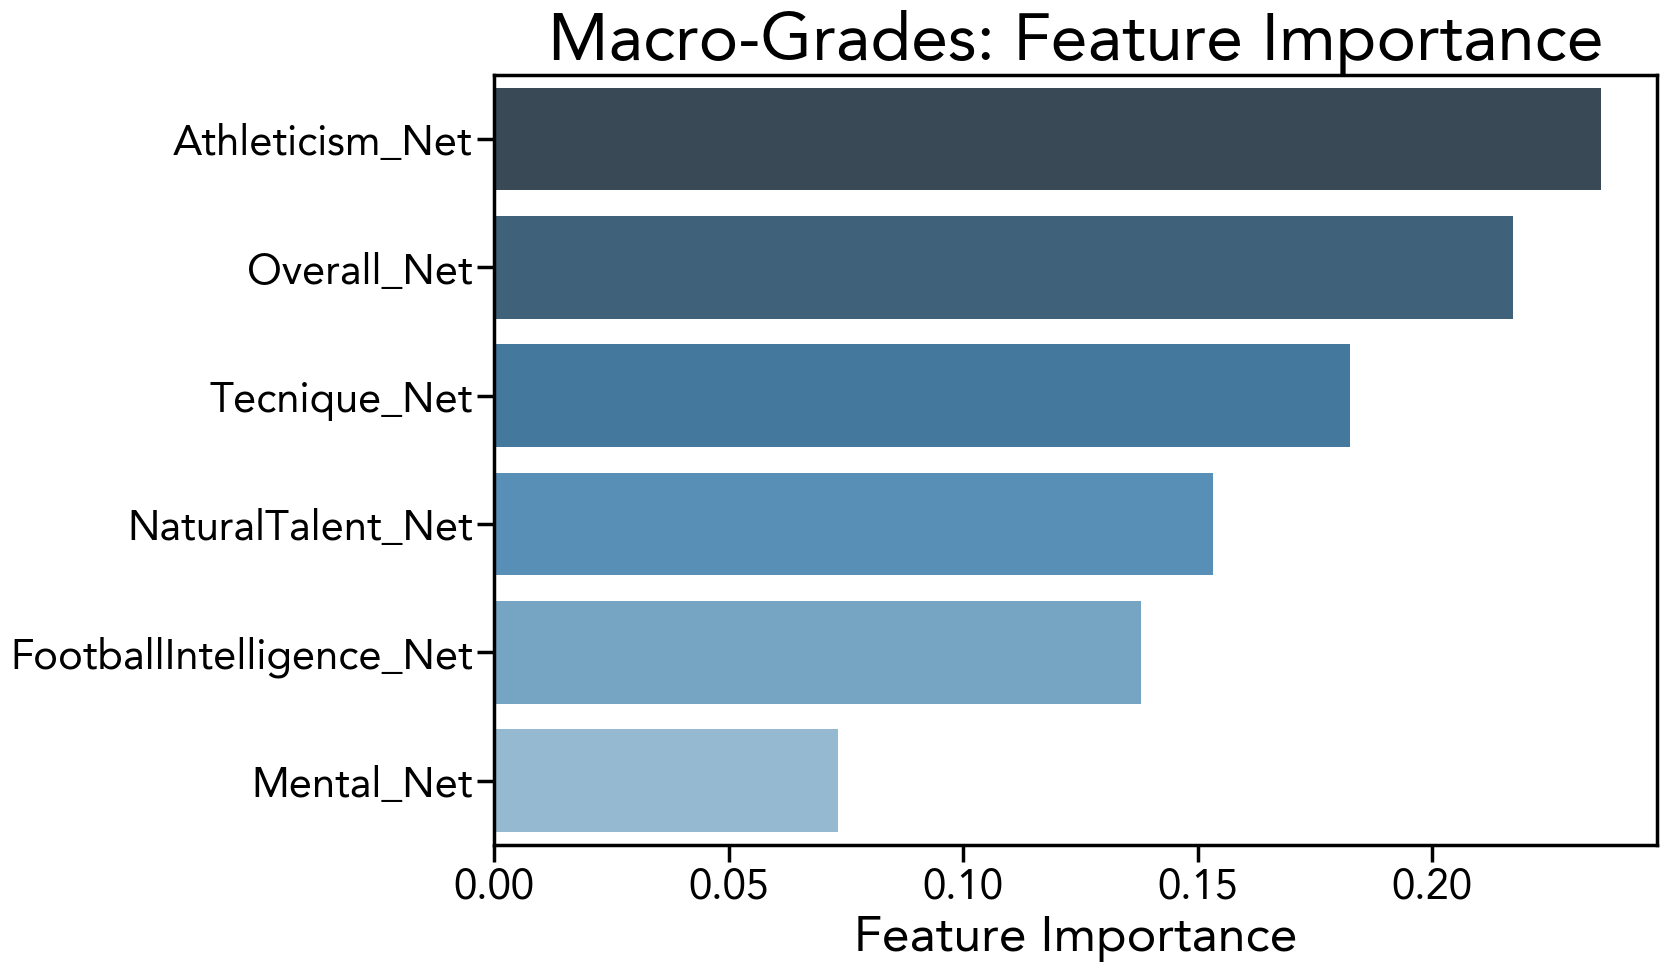

In [37]:
plot_feature_importance(important_tokens, title='Macro-Grades: Feature Importance')

## Grades

In [33]:
path = 'dataset-grades'
filename_1 = 'qb_grades_mental.csv'
filename_2 = 'qb_grades_athleticism.csv'
filename_3 = 'qb_grades_technique.csv'
filename_4 = 'qb_grades_naturaltalent.csv'
filename_5 = 'qb_grades_footballintelligence.csv'

men = pd.read_csv(os.path.join(path, filename_1))
ath = pd.read_csv(os.path.join(path, filename_2))
tec = pd.read_csv(os.path.join(path, filename_3))
nat = pd.read_csv(os.path.join(path, filename_4))
fin = pd.read_csv(os.path.join(path, filename_5))

In [34]:
df = men.merge(ath, how='left', on=['Player', 'Year', 'Race']).merge(tec, how='left', on=['Player', 'Year', 'Race']).merge(nat, how='left', on=['Player', 'Year', 'Race']).merge(fin, how='left', on=['Player', 'Year', 'Race'])
df

,Player,Year,Race,Mental_Count,Leadership_Count,Leadership_Negative,Leadership_Positive,Leadership_Net,Competitor_Count,Competitor_Negative,...,ReadingDefense_Positive,ReadingDefense_Net,Progressions_Count,Progressions_Negative,Progressions_Positive,Progressions_Net,PocketPresence_Count,PocketPresence_Negative,PocketPresence_Positive,PocketPresence_Net
0,Chris Leak,2007,Non-White,2,1,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
1,John Beck,2007,White,2,0,0.0,0.0,0.0,1,0.0,...,0.0,0.0,0,0.000000,0.000000,0.000000,1,0.000000,1.000000,1.000000
2,Drew Stanton,2007,White,3,1,0.0,1.0,1.0,1,0.0,...,0.0,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
3,Matt Flynn,2008,White,3,0,0.0,0.0,0.0,1,1.0,...,0.0,0.0,4,0.250000,0.750000,0.500000,3,0.000000,1.000000,1.000000
4,Chad Henne,2008,White,4,1,1.0,0.0,-1.0,1,0.0,...,0.0,0.0,2,0.000000,1.000000,1.000000,3,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,Mac Jones,2021,White,4,0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,3,0.333333,0.666667,0.333333,7,0.142857,0.857143,0.714286
208,Sam Ehlinger,2021,White,6,2,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0,0.000000,0.000000,0.000000,1,1.000000,0.000000,-1.000000
209,Shane Buechele,2021,White,1,0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
210,Justin Fields,2021,Non-White,8,2,0.0,1.0,1.0,1,0.0,...,0.0,0.0,3,0.333333,0.666667,0.333333,7,0.428571,0.571429,0.142857


In [35]:
# Split into Training and Test Data
X_train = df[['Leadership_Net', 'Competitor_Net', 'Toughness_Net', 'Clutch_Net', 'Confidence_Net', 'RunningAbility_Net', 'Athletic_Net', 'Escapability_Net', 'Release_Net',
       'Mechanics_Net', 'Footwork_Net', 'Accuracy_Net','Armstrength_Net', 'PlayMaker_Net', 'Improvisation_Net', 'Rare_Gifted_Net',
       'FootballIQ_Net', 'Decision_Making_Net', 'ReadingDefense_Net', 'Progressions_Net', 'PocketPresence_Net']]
y_train = np.asarray(df['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(212, 21)
(212,)


In [36]:
model = sm.Logit(y_train, X_train).fit(maxiter=100000)

Optimization terminated successfully.
         Current function value: 0.497332
         Iterations 6


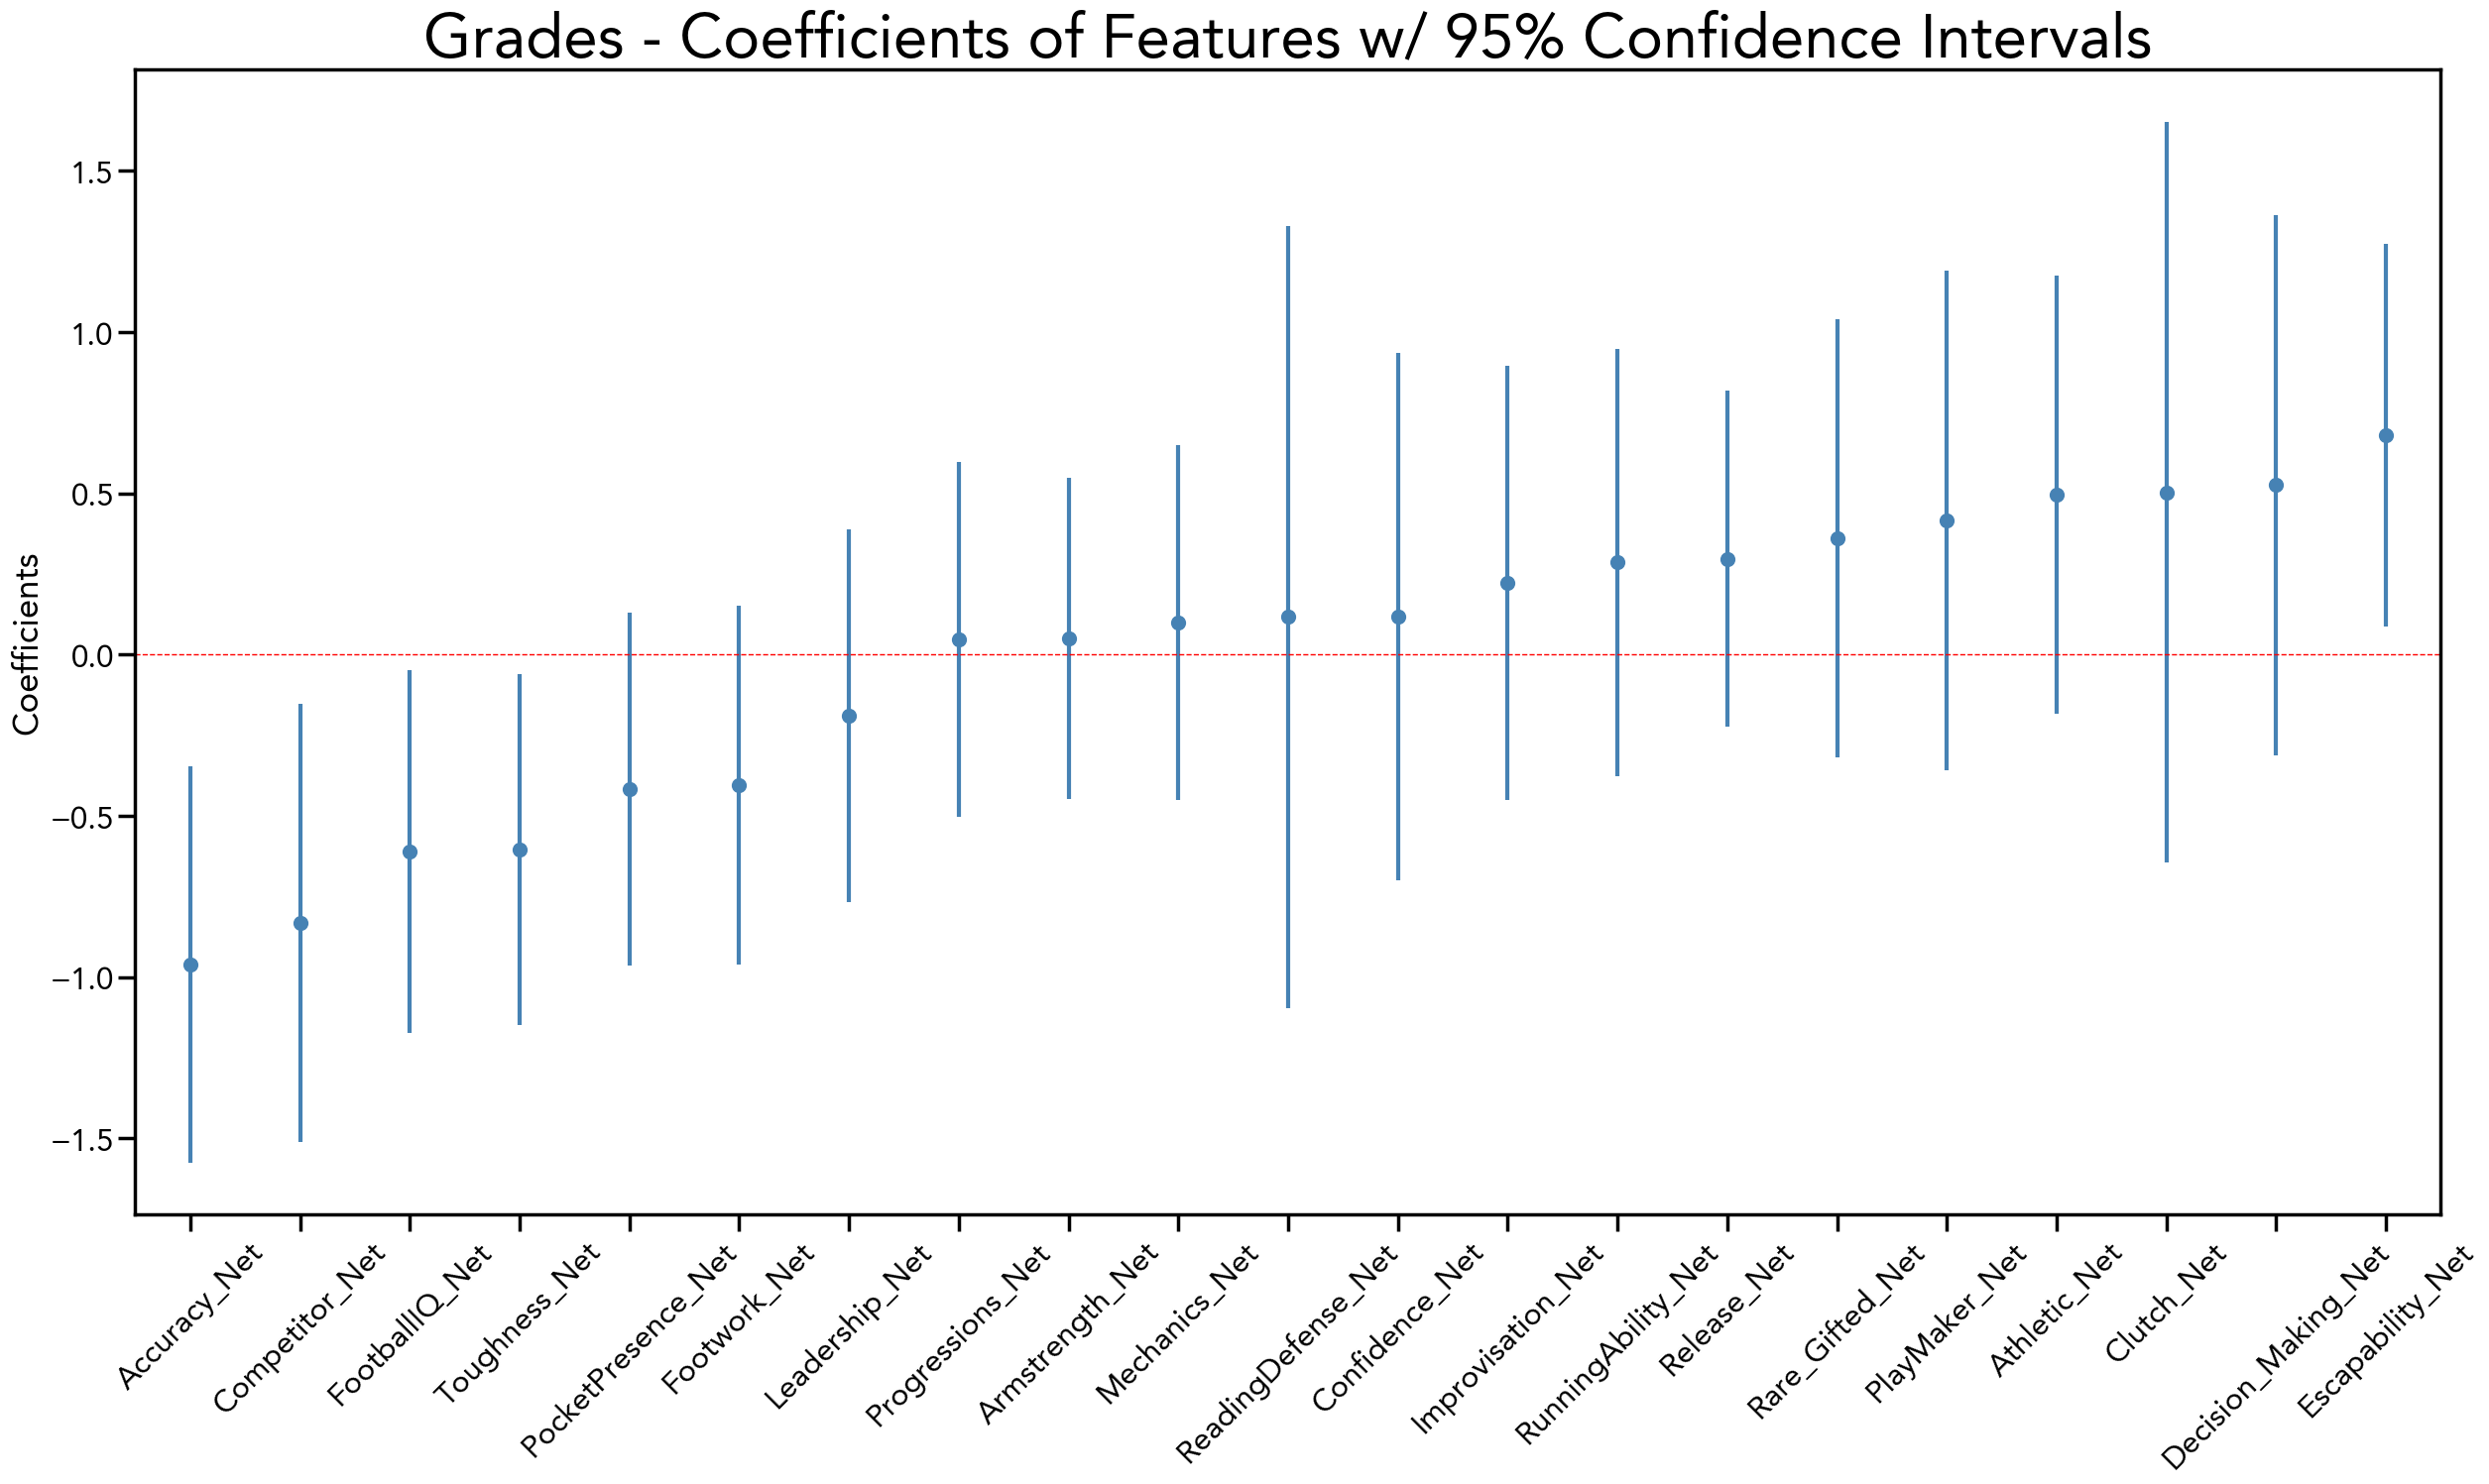

In [42]:
coefplot(model, figsize=(30, 15), sign=False, title='Grades - Coefficients of Features w/ 95% Confidence Intervals', orientation=45)

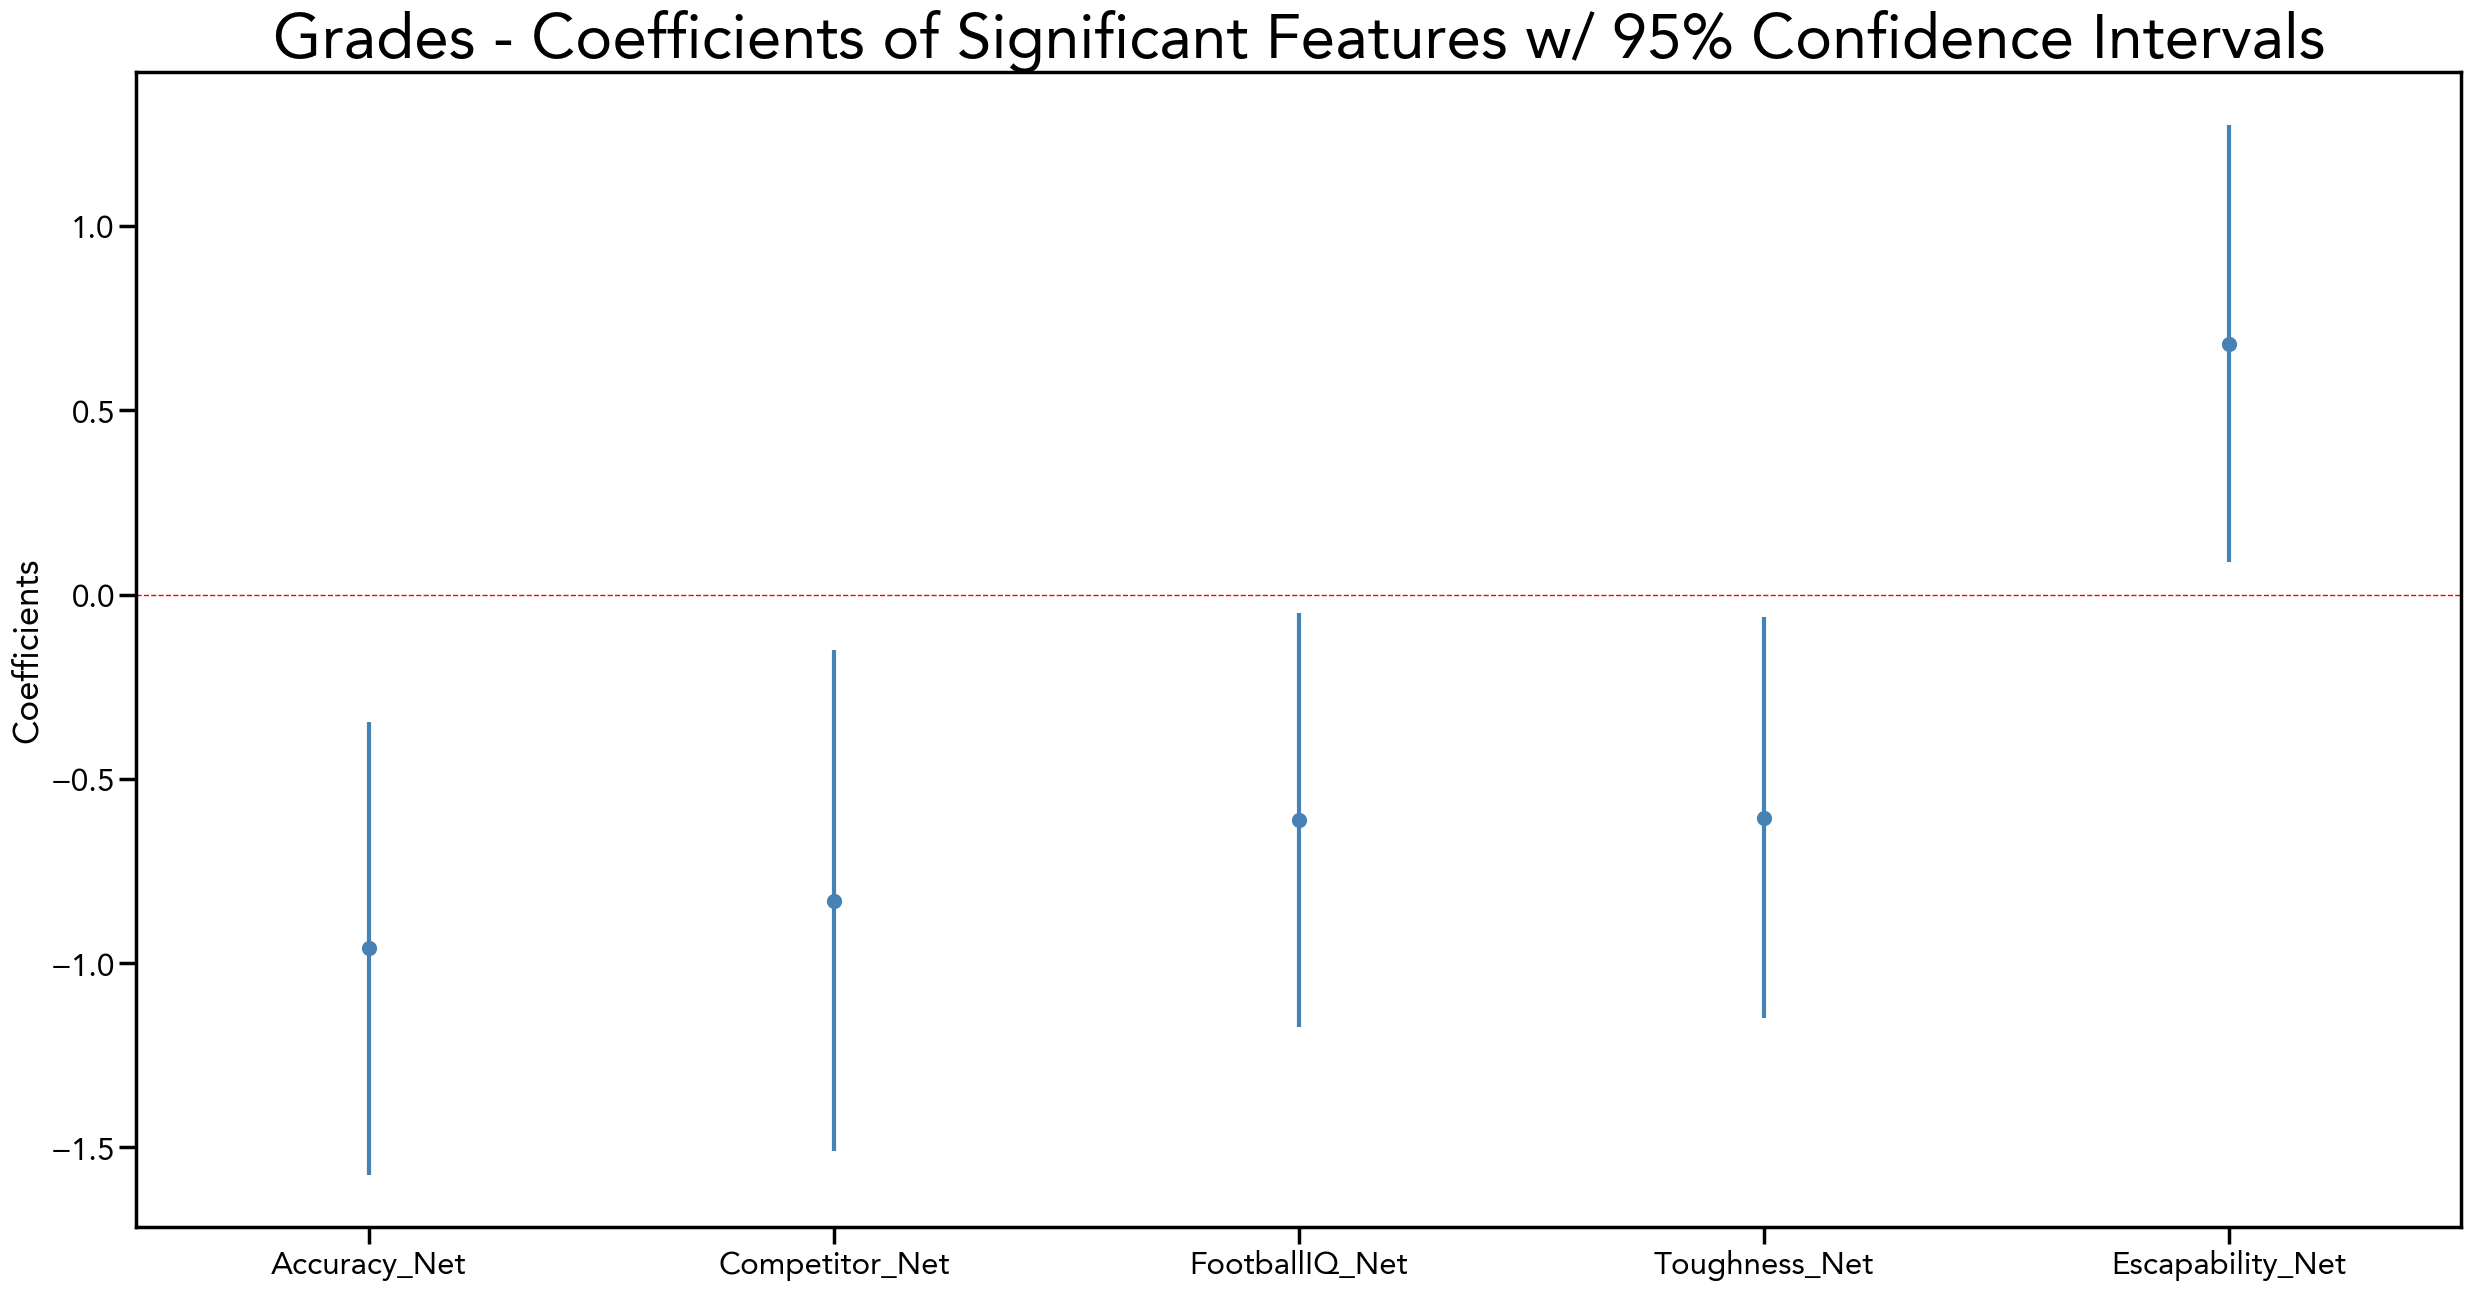

In [43]:
coefplot(model, figsize=(30, 15), sign=True, title='Grades - Coefficients of Significant Features w/ 95% Confidence Intervals')

In [68]:
# Random Forest
grid = {'criterion' : ['gini', 'entropy'],
        'max_depth': [50, 100, None],
        'max_features': ['sqrt'],
        'n_estimators': [100]}

classifier = RandomForestClassifier()
classifier_cv = GridSearchCV(classifier, grid, cv=5, scoring='f1_micro')
classifier_cv.fit(X_train, y_train)

print('Tuned Hyperparameters: ',  classifier_cv.best_params_)
print('F1 :', classifier_cv.best_score_)

Tuned Hyperparameters:  {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}
F1 : 0.7117386489479512


In [44]:
classifier = RandomForestClassifier(criterion='entropy', max_depth=100, max_features='sqrt', n_estimators=100)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100)

In [45]:
features = ['Leadership_Net', 'Competitor_Net', 'Toughness_Net', 'Clutch_Net', 'Confidence_Net', 'RunningAbility_Net', 'Athletic_Net', 'Escapability_Net', 'Release_Net',
            'Mechanics_Net', 'Footwork_Net', 'Accuracy_Net','Armstrength_Net', 'PlayMaker_Net', 'Improvisation_Net', 'Rare_Gifted_Net',
            'FootballIQ_Net', 'Decision_Making_Net', 'ReadingDefense_Net', 'Progressions_Net', 'PocketPresence_Net']
fi = classifier.feature_importances_
importance = [(features[i], fi[i]) for i in range(len(features))]

important_tokens = pd.DataFrame(importance)
important_tokens.columns = ['Feature', 'Importance']
important_tokens = important_tokens.sort_values('Importance', ascending=False)

In [48]:
def plot_feature_importance(df, title):
    
    plt.rcParams['font.family'] = 'Avenir'

    # Create arrays from feature importance and feature names
    feature_importance = np.array(df['Importance'])
    feature_names = np.array(df['Feature'])

    # Create a DataFrame using a Dictionary
    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    fi_df = fi_df.head(50)

    # Define size of bar plot
    plt.figure(figsize=(15, 10))
    
    # Plot Searborn bar chart
    sns.set_palette(reversed(sns.color_palette('Blues_d', n_colors=22)), n_colors=22)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Add chart labels
    plt.title(title, fontsize=36)
    plt.xlabel('Feature Importance', fontsize=24)
    plt.ylabel('', fontsize=24)
    plt.show()

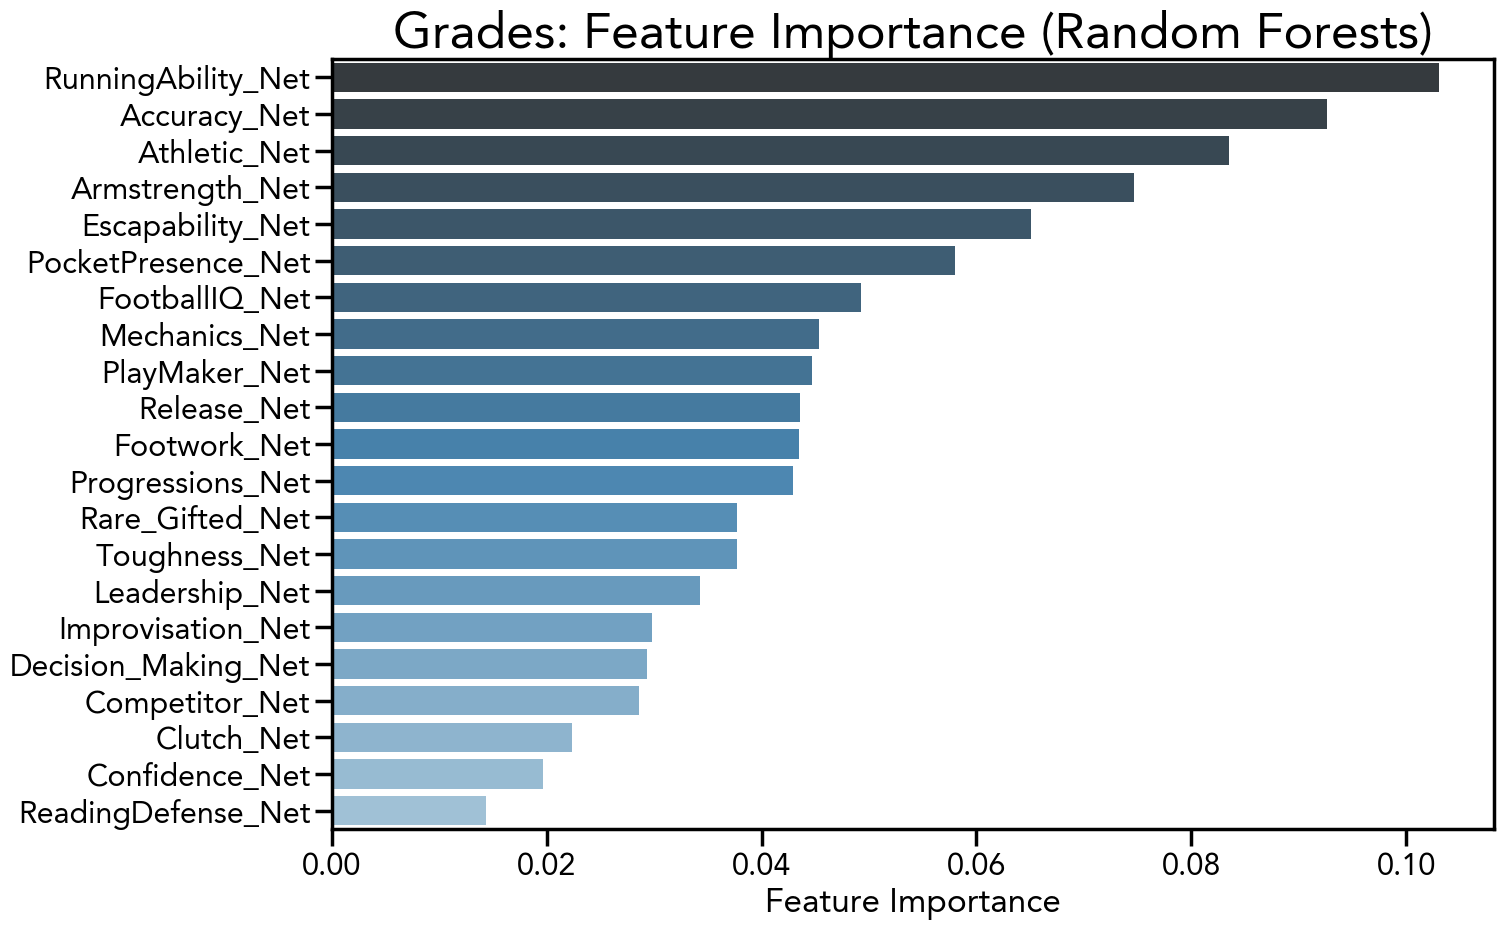

In [49]:
plot_feature_importance(important_tokens, title='Grades: Feature Importance (Random Forests)')